In [4]:
ROOT_DIR = "/home/user/Documents/projects/Metaworld"
%env MUJOCO_GL=egl

import sys
sys.path.append(ROOT_DIR)

import os
import functools
import json
from tqdm import tqdm
import importlib
from dataclasses import dataclass

# scientific
import cv2
import numpy as np
import torch
import pytorch_lightning as pl

# gym
# from gym.spaces import Box
import mujoco
import metaworld
from metaworld import MT1

# plotting
from PIL import Image
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
from lightglue import viz2d

# project imports
# from metaworld.envs.mujoco.sawyer_xyz.test_scripted_policies import ALL_ENVS, test_cases_latest_nonoise
# import reset_space
import utils.camera_utils_v2 as cu
import keyframes.env_utils as env_utils
import keyframes.env_renderer as env_renderer
import keyframes.mujoco_utils as mujoco_utils
import keyframes.keyframe_utils as keyframe_utils
import keyframes.pl_modules as pl_modules
import keyframes.mcc as mcc
import utils.predict_utils as keyframe_predict

import utils.slam_utils as slam_utils
import utils.depth_utils as depth_utils
import utils.match_utils as match_utils
import utils.transform_utils as transform_utils
import utils.inference_utils as inference_utils

import models.extern.mcc_model as mcc_model
import utils.mcc_misc_utils as mcc_misc_utils
import utils.mcc_data_utils as mcc_data_utils
import utils.vis_utils as vis_utils
from pytorch3d.io.obj_io import load_obj


DEVICE = "cuda"


env: MUJOCO_GL=egl


In [3]:
importlib.reload(mcc_model)

<module 'models.extern.mcc_model' from '/home/user/Documents/projects/Metaworld/models/extern/mcc_model.py'>

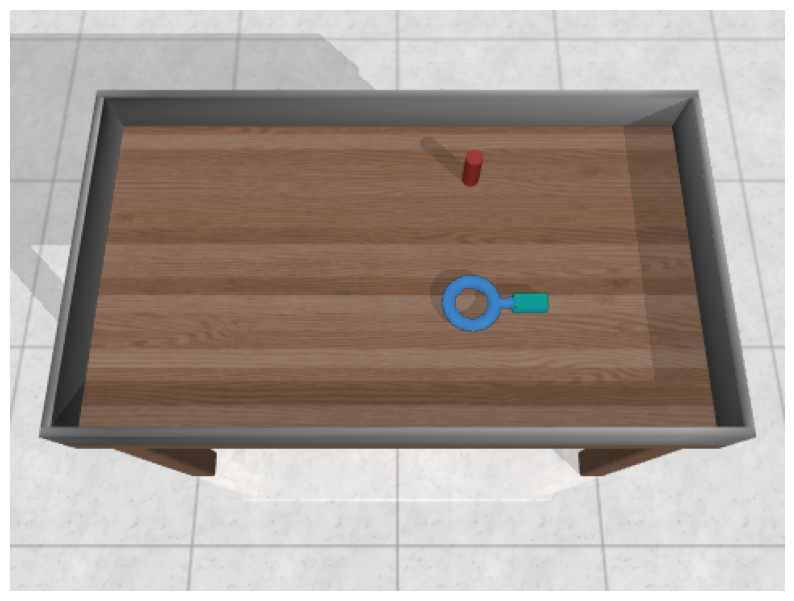

In [6]:
# load demo data
out_folder = "/home/user/Documents/projects/Metaworld/keyframes/test_data"
seg = np.load(f'{out_folder}/seg_assembly.npy')
img = np.load(f'{out_folder}/img_assembly.npy')
xyz = np.load(f'{out_folder}/xyz_assembly.npy')
plt.figure(figsize=(10,10))
plt.imshow(img)
vis_utils.show_mask(seg, plt.gca())
plt.axis('off')
plt.show()

In [57]:
importlib.reload(mcc)

<module 'keyframes.mcc' from '/home/user/Documents/projects/Metaworld/keyframes/mcc.py'>

In [58]:
# create MCC reconstructor
ckpt_path = "/home/user/Documents/projects/osil/co3dv2_all_categories.pth"
reconstructor_mcc = mcc.ReconstructMCC(ckpt_path, DEVICE)

Resume checkpoint /home/user/Documents/projects/osil/co3dv2_all_categories.pth
_IncompatibleKeys(missing_keys=[], unexpected_keys=['mask_token'])


In [59]:
# predict
reconstructor_mcc.set_model_input(img, seg, xyz)
pred_occupy, pred_colors, occupy_threshold, verts, faces, vert_normals, values = reconstructor_mcc.reconstruct()

  0%|          | 0/256 [00:00<?, ?it/s]

100%|██████████| 256/256 [00:53<00:00,  4.81it/s]


torch.Size([492, 3])


100%|██████████| 1/1 [00:00<00:00, 16.29it/s]


In [61]:
max_pts = 50000
is_occupied = pred_occupy > occupy_threshold
pts = reconstructor_mcc.model_input["unseen_xyz"][0][is_occupied, :].cpu().numpy().T
pts_color = pred_colors[is_occupied, :].cpu().numpy()
pts = pts[:,:max_pts]
pts_color = pts_color[:max_pts,:]
print(pts.shape, pts_color.shape)

(3, 7595) (7595, 3)


In [62]:
# visualize
fig = go.Figure(
    data=[
        go.Scatter3d(
            x=pts[0],
            y=pts[1],
            z=pts[2],
            mode="markers",
            marker=dict(
                size=1,
                color=pts_color * 255,                # set color to an array/list of desired values
                #colorscale="Viridis",  # choose a colorscale
                opacity=1.0,
            ),
        ),
        go.Scatter3d(
            x=reconstructor_mcc.model_input["seen_xyz"][reconstructor_mcc.model_input["is_valid"]][:,0].cpu().numpy(),
            y=reconstructor_mcc.model_input["seen_xyz"][reconstructor_mcc.model_input["is_valid"]][:,1].cpu().numpy(),
            z=reconstructor_mcc.model_input["seen_xyz"][reconstructor_mcc.model_input["is_valid"]][:,2].cpu().numpy(),
            mode="markers",
            marker=dict(
                size=2,
                # color=xy_c0[2],                # set color to an array/list of desired values
                color="red",  # choose a colorscale
                opacity=0.8,
            ),
        ),

    ]
)

fig.update_layout(
    autosize=True,
    width=800,
    height=600,
    # scene_aspectmode='cube'
    scene_aspectmode='data'
)

## Old

In [4]:
@dataclass
class MCCConfig:
    # Model
    checkpoint: str
    resume: str
    eval: bool = True

    input_size: int = 224
    device: str = "cuda"  # cuda or cpu
    drop_path: float = 0.1  # drop_path probability
    regress_color: bool = False  # If true, regress color with MSE. Otherwise, 256-way classification for each channel.
    shrink_threshold: float = 10  # Any points with distance beyond this value will be shrunk.

    # rgb_weight: float = 0.01  # A constant to weight the color prediction loss
    # occupancy_weight: float = 1.0  # A constant to weight the occupancy loss
    # n_queries: int = 550  # Number of queries used in decoder.
    # embed_dim: int = 1024
    # depth: int = 24
    # num_heads: int = 16
    # decoder_embed_dim: int = 512
    # decoder_depth: int = 8
    # decoder_num_heads: int = 16
    # mlp_ratio: float = 4.
    # img_size: int = 224
    # patch_size: int = 16
    # in_chans: int = 3
    # norm_layer: partial(nn.LayerNorm, eps=1e-6)


def load_model(ckpt_path: str, input_size=224, device="cuda"):
    args = MCCConfig(input_size=input_size, checkpoint=ckpt_path, resume=ckpt_path, device=device)
    
    model = mcc_model.get_mcc_model(
        occupancy_weight=1.0,
        rgb_weight=0.01,
        args=args,
    ).cuda()  # TODO this should be device agnostic

    mcc_misc_utils.load_model(args=args, model_without_ddp=model, optimizer=None, loss_scaler=None)

    return model


In [5]:
model = load_model(ckpt_path)

Resume checkpoint /home/user/Documents/projects/osil/co3dv2_all_categories.pth
_IncompatibleKeys(missing_keys=[], unexpected_keys=['mask_token'])


In [6]:
def normalize_xyz_v2(seen_xyz):
    is_valid = torch.isfinite(seen_xyz.sum(dim=-1))
    seen_xyz_mean = seen_xyz[is_valid].mean(dim=0)
    seen_xyz = seen_xyz - seen_xyz_mean
    seen_xyz_max_dist = torch.max(torch.abs(seen_xyz[is_valid]))
    seen_xyz /= seen_xyz_max_dist
    return seen_xyz, seen_xyz_mean, seen_xyz_max_dist

def get_model_input(img, depth_pts, seg, grid_size=1, grid_granularity=0.01, device="cuda"):
    """
    Args:
        img: (3, W, H) torch.Tensor
        depth_pts: (H, W, 3) torch.Tensor
        seg: (H, W) torch.Tensor
        grid_size: float
        grid_granularity: float
        device: str
    """

    # normalize rgb image
    seen_rgb = (torch.tensor(img).float() / 255)[..., [2, 1, 0]] # shape: (H, W, 3)
    img_height, img_width = seen_rgb.shape[:2]

    # TODO why interpolate to the same size?
    #       => This should be depth_pts.shape[:2] ???
    depth_pts = torch.tensor(depth_pts).float()  # shape: (H, W, 3)
    if depth_pts.shape[:2] != (img_height, img_width):
        depth_pts = torch.nn.functional.interpolate(
            depth_pts.permute(2, 0, 1)[None],  # shape: (1, 3, H, W)
            size=[img_height, img_width],
            mode="bilinear",
            align_corners=False,
        )[0].permute(1, 2, 0)  # shape: (H, W, 3)

    seen_xyz = depth_pts
    
    mask = torch.tensor(cv2.resize(seg.astype(float), (img_width, img_height))).bool()
    seen_xyz[~mask] = float('inf')

    # seen_xyz = mcc_data_utils.normalize_xyz(seen_xyz)
    seen_xyz, _, _ = normalize_xyz_v2(seen_xyz)

    # cut out masked region
    bottom, right = mask.nonzero().max(dim=0)[0]
    top, left = mask.nonzero().min(dim=0)[0]
    bottom = bottom + 40
    right = right + 40
    top = max(top - 40, 0)
    left = max(left - 40, 0)
    seen_xyz = seen_xyz[top:bottom+1, left:right+1]
    seen_rgb = seen_rgb[top:bottom+1, left:right+1]
    seen_xyz = mcc_data_utils.make_square_image(seen_xyz, float('inf'))
    seen_rgb = mcc_data_utils.make_square_image(seen_rgb, 0)

    # resize rgb image to 800x800
    seen_rgb = torch.nn.functional.interpolate(
        seen_rgb.permute(2, 0, 1)[None],  # shape: (1, 3, H, W)
        size=[800, 800],
        mode="bilinear",
        align_corners=False,
    )  # shape: (1, 3, 800, 800)

    # resize depth points image to 112x112
    seen_xyz = torch.nn.functional.interpolate(
        seen_xyz.permute(2, 0, 1)[None],  # shape: (1, 3, H, W)
        size=[112, 112],
        mode="bilinear",
        align_corners=False,
    ).permute(0, 2, 3, 1)  # shape: (1, 112, 112, 3)

    # sample query points and create dummy rgb, is_valid, and is_seen tensors
    valid_seen_xyz, is_valid = mcc_data_utils.remove_inf_from_xyz(seen_xyz)
    unseen_xyz = mcc_data_utils.sample_unseen_xyz(
        batch_size = 1,
        grid_size=grid_size,
        grid_granularity=grid_granularity,
        device=device
    )
    is_seen = torch.zeros((unseen_xyz.shape[0], unseen_xyz.shape[1]), device=device).bool()
    unseen_rgb = torch.zeros_like(unseen_xyz)

    return {
        "seen_xyz": valid_seen_xyz,
        "seen_rgb": seen_rgb,
        "unseen_xyz": unseen_xyz,  # query points
        "unseen_rgb": unseen_rgb,  # only used for loss => not needed for inference
        "is_seen": is_seen,  # only used for loss => not needed for inference
        "is_valid": is_valid,  # only used for loss => not needed for inference
    }

In [7]:
# TODO create input data
# TODO run inference
# TODO visualize results

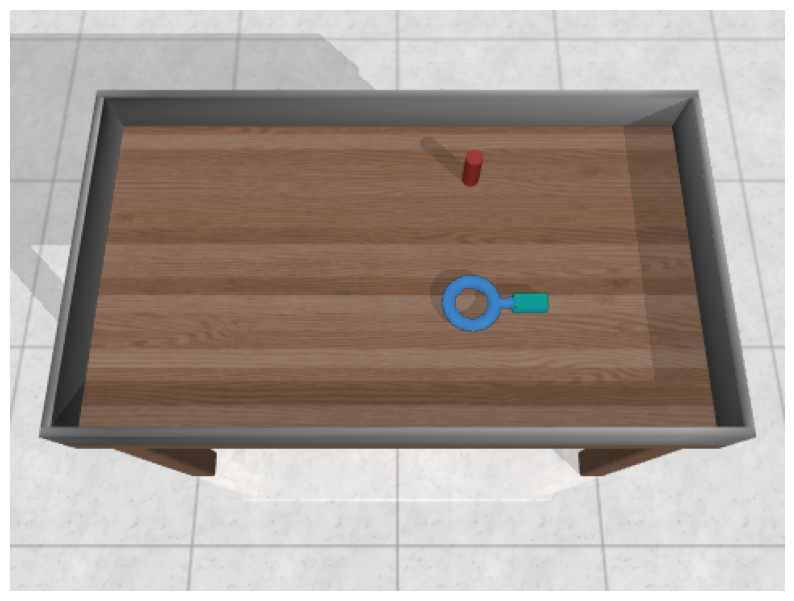

In [14]:
xyz_obj = xyz[seg.reshape(-1)]
print(np.min(xyz_obj, axis=0), np.max(xyz_obj, axis=0))

[0.09851682 0.44875269 0.00103974] [0.33126433 0.57639526 0.03704038]


In [15]:
0.57639526 - 0.44875269

0.12764256999999996

/home/user/Documents/projects/osil/src/pytorch3d/pytorch3d/io/obj_io.py:544: UserWarning: No mtl file provided
  warnings.warn("No mtl file provided")


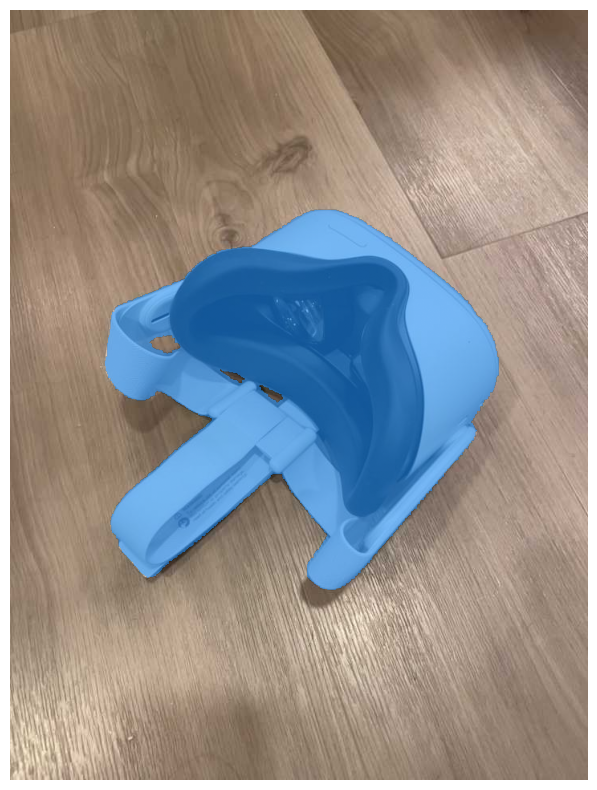

In [9]:
quest2_rgb = cv2.imread(f'{out_folder}/quest2.jpg')
quest2_rgb = quest2_rgb[..., [2, 1, 0]]
quest2_obj = load_obj(f'{out_folder}/quest2.obj')
H, W = quest2_rgb.shape[:2]
quest2_seen_xyz = quest2_obj[0].reshape(H, W, 3)
quest2_seg = cv2.imread(f'{out_folder}/quest2_seg.png', cv2.IMREAD_UNCHANGED)
plt.figure(figsize=(10,10))
plt.imshow(quest2_rgb)
vis_utils.show_mask(quest2_seg, plt.gca())
plt.axis('off')
plt.show()

In [10]:
def predict_mcc(
    model: torch.nn.Module, 
    model_input: dict, 
    temperature=0.1,  # temperature for color prediction.
):
    model.eval()

    seen_rgb = model_input["seen_rgb"]
    seen_xyz = model_input["seen_xyz"]
    valid_seen_xyz = model_input["is_valid"]
    unseen_xyz = model_input["unseen_xyz"]
    unseen_rgb = model_input["unseen_rgb"]
    labels = model_input["is_seen"]

    pred_occupy = []
    pred_colors = []

    max_n_query_points = 2000

    model.cached_enc_feat = None
    num_passes = int(np.ceil(unseen_xyz.shape[1] / max_n_query_points))
    for p_idx in tqdm(range(num_passes)):
        p_start = p_idx     * max_n_query_points
        p_end = (p_idx + 1) * max_n_query_points
        cur_unseen_xyz = unseen_xyz[:, p_start:p_end]
        cur_unseen_rgb = unseen_rgb[:, p_start:p_end].zero_()
        cur_labels = labels[:, p_start:p_end].zero_()

        with torch.no_grad():
            _, pred = model(
                seen_images=seen_rgb,
                seen_xyz=seen_xyz,
                unseen_xyz=cur_unseen_xyz,
                unseen_rgb=cur_unseen_rgb,
                unseen_occupy=cur_labels,
                cache_enc=True,
                valid_seen_xyz=valid_seen_xyz,
            )
        pred_occupy.append(pred[..., 0].cpu())
        pred_colors.append(
            (
                torch.nn.Softmax(dim=2)(
                    pred[..., 1:].reshape((-1, 3, 256)) / temperature
                ) * torch.linspace(0, 1, 256, device=pred.device)
            ).sum(axis=2)
        )
    return torch.cat(pred_occupy, dim=1), torch.cat(pred_colors, dim=0)

In [11]:
model_input = get_model_input(
    # quest2_rgb,
    # quest2_seen_xyz,
    # quest2_seg,
    img, 
    xyz.reshape(img.shape), 
    seg, 
    grid_size=2, 
    grid_granularity=0.025, 
    device="cuda"
)
for k, v in model_input.items():
    print(k, v.shape)
model.to(DEVICE)
for k, v in model_input.items():
    model_input[k] = v.to(DEVICE)
pred_occupy, pred_colors = predict_mcc(model, model_input)
pred_colors = pred_colors[None, :, :]

seen_xyz torch.Size([1, 112, 112, 3])
seen_rgb torch.Size([1, 3, 800, 800])
unseen_xyz torch.Size([1, 512000, 3])
unseen_rgb torch.Size([1, 512000, 3])
is_seen torch.Size([1, 512000])
is_valid torch.Size([1, 112, 112])


100%|██████████| 256/256 [00:57<00:00,  4.46it/s]


In [16]:
pred_colors.shape

torch.Size([1, 512000, 3])

In [17]:
pred_occupy.shape

torch.Size([1, 512000])

In [18]:
model_input["unseen_xyz"][0].shape

torch.Size([512000, 3])

In [13]:
max_pts = 50000
is_occupied = pred_occupy[0] > 5.0
pts = model_input["unseen_xyz"][0][is_occupied, :].cpu().numpy().T
pts_color = pred_colors[0][is_occupied, :].cpu().numpy()
pts = pts[:,:max_pts]
pts_color = pts_color[:max_pts,:]
print(pts.shape, pts_color.shape)

(3, 7468) (7468, 3)


In [14]:
pred_occupy[0].max()

tensor(10.3636)

In [15]:
k = 0

fig = go.Figure(
    data=[
        go.Scatter3d(
            x=pts[0],
            y=pts[1],
            z=pts[2],
            mode="markers",
            marker=dict(
                size=1,
                color=pts_color * 255,                # set color to an array/list of desired values
                #colorscale="Viridis",  # choose a colorscale
                opacity=1.0,
            ),
        ),
        go.Scatter3d(
            x=model_input["seen_xyz"][model_input["is_valid"]][:,0].cpu().numpy(),
            y=model_input["seen_xyz"][model_input["is_valid"]][:,1].cpu().numpy(),
            z=model_input["seen_xyz"][model_input["is_valid"]][:,2].cpu().numpy(),
            mode="markers",
            marker=dict(
                size=2,
                # color=xy_c0[2],                # set color to an array/list of desired values
                color="red",  # choose a colorscale
                opacity=0.8,
            ),
        ),

    ]
)

fig.update_layout(
    autosize=True,
    width=800,
    height=600,
    # scene_aspectmode='cube'
    scene_aspectmode='data'
)

# fig.update_yaxes(
#     scaleanchor = "x",
#     scaleratio = 1,
# )

# fig.update_zaxes(
#     scaleanchor = "x",
#     scaleratio = 1,
# )

In [19]:
np.save(f'{out_folder}/assembly_unseen_xyz.npy', model_input["unseen_xyz"][0].cpu().numpy())
np.save(f'{out_folder}/assembly_pred_occupy.npy', pred_occupy[0].cpu().numpy())
np.save(f'{out_folder}/assembly_pred_color.npy', pred_colors[0].cpu().numpy())

np.save(f'{out_folder}/assembly_seen_xyz.npy', model_input["seen_xyz"][0].cpu().numpy())
np.save(f'{out_folder}/assembly_seen_rgb.npy', model_input["seen_rgb"][0].cpu().numpy())
np.save(f'{out_folder}/assembly_is_valid.npy', model_input["is_valid"][0].cpu().numpy())
np.save(f'{out_folder}/assembly_is_seen.npy', model_input["is_seen"][0].cpu().numpy())

In [24]:
from pytorch3d.structures import Pointclouds
from pytorch3d.vis.plotly_vis import plot_scene

In [ ]:
import matplotlib.pyplot as plt

pc = Pointclouds(
            points=points[good_points][None].cpu(),
            features=features[good_points][None].cpu(),
        )

        clouds["MCC Output"][f"pred_{t}"] = pc

    plt.figure()
    try:
        fig = plot_scene(clouds, pointcloud_marker_size=pointcloud_marker_size, pointcloud_max_points=20000 * 2)
        fig.update_layout(height=1000, width=1000)

In [ ]:
model = load_model(ckpt_path=ckpt_path)
img, seg, depth_pts = None, None, None
model_input = get_model_input(img, depth_pts, seg)


In [ ]:
# Model
    parser.add_argument('--input_size', default=224, type=int,
                        help='Images input size')
    parser.add_argument('--occupancy_weight', default=1.0, type=float,
                        help='A constant to weight the occupancy loss')
    parser.add_argument('--rgb_weight', default=0.01, type=float,
                        help='A constant to weight the color prediction loss')
    parser.add_argument('--n_queries', default=550, type=int,
                        help='Number of queries used in decoder.')
    parser.add_argument('--drop_path', default=0.1, type=float,
                        help='drop_path probability')
    parser.add_argument('--regress_color', action='store_true',
                        help='If true, regress color with MSE. Otherwise, 256-way classification for each channel.')

    # Training
    parser.add_argument('--batch_size', default=16, type=int,
                        help='Batch size per GPU for training (effective batch size is batch_size * accum_iter * # gpus')
    parser.add_argument('--eval_batch_size', default=2, type=int,
                        help='Batch size per GPU for evaluation (effective batch size is batch_size * accum_iter * # gpus')
    parser.add_argument('--epochs', default=100, type=int)
    parser.add_argument('--accum_iter', default=1, type=int,
                        help='Accumulate gradient iterations (for increasing the effective batch size under memory constraints)')
    parser.add_argument('--weight_decay', type=float, default=0.05,
                        help='Weight decay (default: 0.05)')
    parser.add_argument('--lr', type=float, default=None, metavar='LR',
                        help='Learning rate (absolute lr)')
    parser.add_argument('--blr', type=float, default=1e-4, metavar='LR',
                        help='Base learning rate: absolute_lr = base_lr * total_batch_size / 512')
    parser.add_argument('--min_lr', type=float, default=0., metavar='LR',
                        help='Lower lr bound for cyclic schedulers that hit 0')
    parser.add_argument('--warmup_epochs', type=int, default=5, metavar='N',
                        help='Epochs to warmup LR')
    parser.add_argument('--clip_grad', type=float, default=1.0,
                        help='Clip gradient at the specified norm')

    # Job
    parser.add_argument('--job_dir', default='',
                        help='Path to where to save, empty for no saving')
    parser.add_argument('--output_dir', default='./output_dir',
                        help='Path to where to save, empty for no saving')
    parser.add_argument('--device', default='cuda',
                        help='Device to use for training / testing')
    parser.add_argument('--seed', default=0, type=int,
                        help='Random seed.')
    parser.add_argument('--resume', default='',
                        help='Resume from checkpoint')

    parser.add_argument('--start_epoch', default=0, type=int, metavar='N',
                        help='Start epoch')
    parser.add_argument('--num_workers', default=4, type=int,
                        help='Number of workers for training data loader')
    parser.add_argument('--num_eval_workers', default=4, type=int,
                        help='Number of workers for evaluation data loader')
    parser.add_argument('--pin_mem', action='store_true',
                        help='Pin CPU memory in DataLoader for more efficient (sometimes) transfer to GPU.')
    parser.add_argument('--no_pin_mem', action='store_false', dest='pin_mem')
    parser.set_defaults(pin_mem=True)

    # Distributed training
    parser.add_argument('--world_size', default=1, type=int,
                        help='Number of distributed processes')
    parser.add_argument('--local_rank', default=-1, type=int)
    parser.add_argument('--dist_on_itp', action='store_true')
    parser.add_argument('--dist_url', default='env://',
                        help='Url used to set up distributed training')

    # Experiments
    parser.add_argument('--debug', action='store_true')
    parser.add_argument('--run_viz', action='store_true',
                        help='Specify to run only the visualization/inference given a trained model.')
    parser.add_argument('--max_n_viz_obj', default=64, type=int,
                        help='Max number of objects to visualize during training.')

    # Data
    parser.add_argument('--train_epoch_len_multiplier', default=32, type=int,
                        help='# examples per training epoch is # objects * train_epoch_len_multiplier')
    parser.add_argument('--eval_epoch_len_multiplier', default=1, type=int,
                        help='# examples per eval epoch is # objects * eval_epoch_len_multiplier')

    # CO3D
    parser.add_argument('--co3d_path', type=str, default='co3d_data',
                        help='Path to CO3D v2 data.')
    parser.add_argument('--holdout_categories', action='store_true',
                        help='If true, hold out 10 categories and train on only the remaining 41 categories.')
    parser.add_argument('--co3d_world_size', default=3.0, type=float,
                        help='The world space we consider is \in [-co3d_world_size, co3d_world_size] in each dimension.')

    # Hypersim
    parser.add_argument('--use_hypersim', action='store_true',
                        help='If true, use hypersim, else, co3d.')
    parser.add_argument('--hypersim_path', default="hypersim_data", type=str,
                        help="Path to Hypersim data.")

    # Data aug
    parser.add_argument('--random_scale_delta', default=0.2, type=float,
                        help='Random scaling each example by a scaler \in [1 - random_scale_delta, 1 + random_scale_delta].')
    parser.add_argument('--random_shift', default=1.0, type=float,
                        help='Random shifting an example in each axis by an amount \in [-random_shift, random_shift]')
    parser.add_argument('--random_rotate_degree', default=180, type=int,
                        help='Random rotation degrees.')

    # Smapling, evaluation, and coordinate system
    parser.add_argument('--shrink_threshold', default=10.0, type=float,
                        help='Any points with distance beyond this value will be shrunk.')
    parser.add_argument('--semisphere_size', default=6.0, type=float,
                        help='The Hypersim task predicts points in a semisphere in front of the camera.'
                             'This value specifies the size of the semisphere.')
    parser.add_argument('--eval_granularity', default=0.1, type=float,
                        help='Granularity of the evaluation points.')
    parser.add_argument('--viz_granularity', default=0.1, type=float,
                        help='Granularity of points in visaulizatoin.')

    parser.add_argument('--eval_score_threshold', default=0.1, type=float,
                        help='Score threshold for evaluation.')
    parser.add_argument('--eval_dist_threshold', default=0.1, type=float,
                        help='Points closer than this amount to a groud-truth is considered correct.')
    parser.add_argument('--train_dist_threshold', default=0.1, type=float,
                        help='Points closer than this amount is considered positive in training.')
    return parser

if __name__ == '__main__':
    parser = main_mcc.get_args_parser()
    parser.add_argument('--image', default='demo/quest2.jpg', type=str, help='input image file')
    parser.add_argument('--point_cloud', default='demo/quest2.obj', type=str, help='input obj file')
    parser.add_argument('--seg', default='demo/quest2_seg.png', type=str, help='input obj file')
    parser.add_argument('--output', default='demo/output', type=str, help='output path')
    parser.add_argument('--granularity', default=0.05, type=float, help='output granularity')
    parser.add_argument('--score_thresholds', default=[0.1, 0.2, 0.3, 0.4, 0.5], type=float, nargs='+', help='score thresholds')
    parser.add_argument('--temperature', default=0.1, type=float, help='temperature for color prediction.')
    parser.add_argument('--checkpoint', default='co3dv2_all_categories.pth', type=str, help='model checkpoint')

    parser.set_defaults(eval=True)

    args = parser.parse_args()
    args.resume = args.checkpoint
    args.viz_granularity = args.granularity
    main(args)

In [ ]:
# visualize output